<a href="https://colab.research.google.com/github/ww-Jing/Algorithmic_Trading/blob/main/LSTM_stock_predict2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install sklearn
!pip install keras 
!pip yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "yfinance"


In [4]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns 

import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Flatten, Dense, LSTM, ConvLSTM2D
from sklearn.metrics import mean_squared_error

[*********************100%***********************]  1 of 1 completed


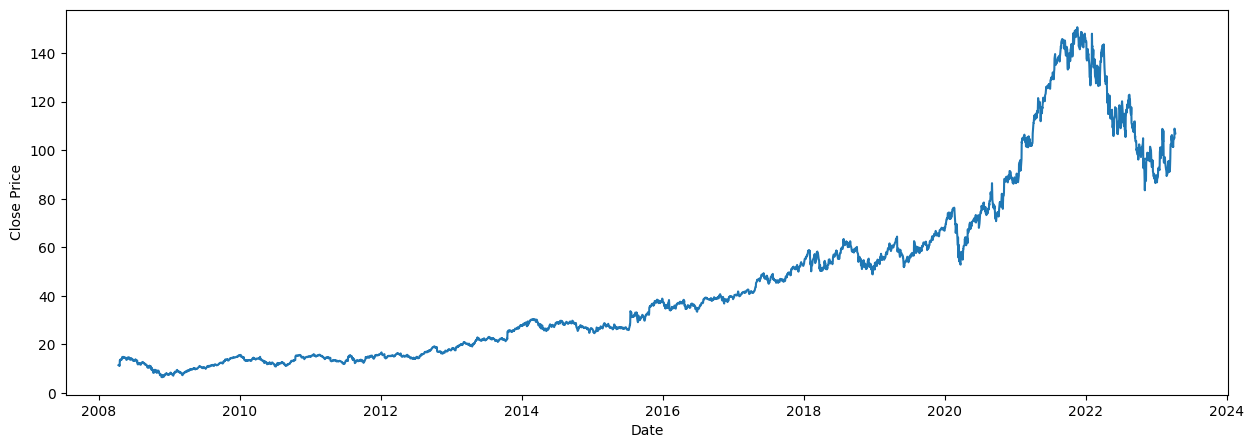

In [18]:
tf = datetime.now()
ti = datetime(tf.year -15 , tf.month, tf.day)

Stock = yf.download('GOOG', ti, tf).reset_index()

plt.figure(figsize=(15,5))
plt.plot(Stock['Date'],Stock['Close'])
plt.xlabel('Date', fontsize=10)
plt.ylabel('Close Price', fontsize=10)
plt.show()

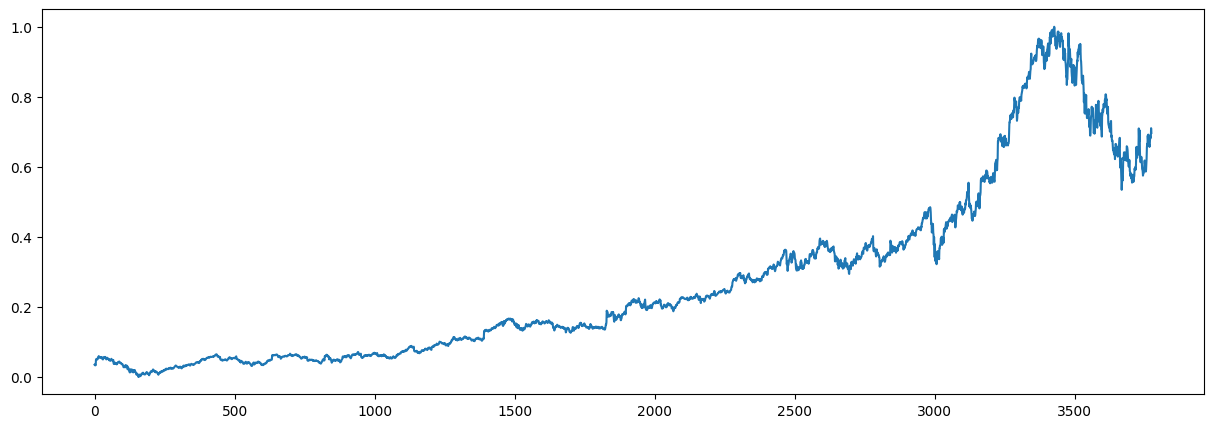

In [20]:
Stock_close = Stock.filter(['Close']).values

scaler = MinMaxScaler(feature_range=(0,1))
Stock_close_scaler = scaler.fit_transform(Stock_close)
plt.figure(figsize = (15,5))
plt.plot(Stock_close_scaler)
plt.show()

In [21]:
def data_split(data_set, spilt_ratio):
  train_len = int(len(data_set)* spilt_ratio)
  test_len = len(data_set) - train_len

  train_data = data_set[0:train_len, :]
  test_data = data_set[train_len:len(data_set),:]
  return train_data, test_data

def to_seq(data_set, seq_len):
  x = []
  y = []

  for i in range(len(data_set)-seq_len-1):
    x.append(data_set[i:(i + seq_len), 0 ])
    y.append(data_set[i+seq_len, 0])
  return np.array(x), np.array(y)

In [22]:
train_data, test_data = data_split(Stock_close_scaler, 0.66)
seq_len = 10
x_train, y_train = to_seq(train_data, seq_len)
x_test, y_test = to_seq(test_data, seq_len)

In [23]:
x_train = x_train.reshape((x_train.shape[0], 1, 1, 1, seq_len))
x_test = x_test.reshape((x_test.shape[0], 1, 1, 1, seq_len))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_len)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), verbose = 0, epochs = 250)

predict_train = model.predict(x_train)
predict_test =  model.predict(x_test)

40/40 [==============================] - 0s 2ms/step


In [11]:
predict_train = scaler.inverse_transform(predict_train)
y_train = scaler.inverse_transform([y_train])
predict_test =  scaler.inverse_transform(predict_test)
y_test = scaler.inverse_transform([y_test])

In [12]:
train_score = math.sqrt(mean_squared_error(y_train[0], predict_train[:,0]))
print("train_RMSE = {}".format(train_score))
test_score = math.sqrt(mean_squared_error(y_test[0], predict_test[:,0]))
print("test_RMSE = {}".format(test_score))

train_RMSE = 0.3885845889794603
test_RMSE = 3.681268454925844


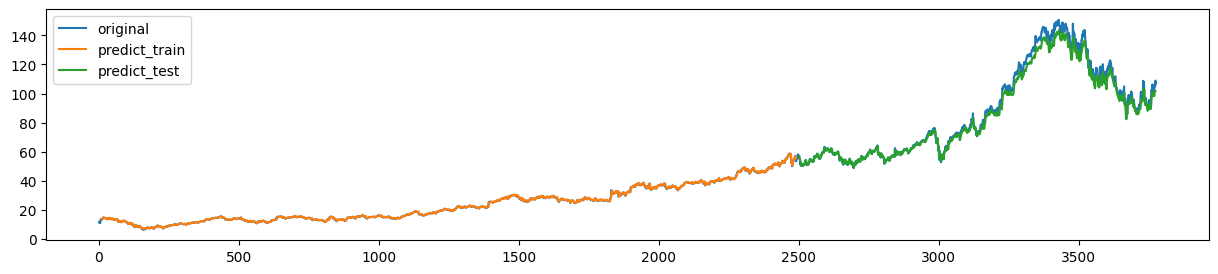

In [15]:
trainPredictPlot = np.empty_like(Stock_close_scaler)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_len:len(predict_train)+seq_len, :] = predict_train

testPredictPlot = np.empty_like(Stock_close_scaler)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(predict_train)+(seq_len*2)+1:len(Stock_close_scaler)-1, :] = predict_test

plt.figure(figsize=(15,3))
plt.plot(scaler.inverse_transform(Stock_close_scaler), label='original')
plt.plot(trainPredictPlot, label='predict_train')
plt.plot(testPredictPlot, label='predict_test')
plt.legend()
plt.show()